# Data Preparation
PlantVillage dataset: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
- over 50,000 expertly curated images on healthy and infected leaves of crops plants
- 38 classes

Since we're focusing on image classification for now, we will only use and pre-process the images in the 'color' folder.

In [ ]:
# !pip install tensorflow
# !pip install seaborn

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Loading dataset
base_path = 'plantvillage_dataset'
color_path = os.path.join(base_path, 'color')
# gray_path = os.path.join(base_path, 'grayscale')
# segment_path = os.path.join(base_path, 'segmented')

### 0. Create a dataframe
- with the columns: image path, label, plant type and type of disease.

In [ ]:
data = []
classes = sorted([d for d in os.listdir(color_path) if os.path.isdir(os.path.join(color_path, d))])

for cls in classes:
    class_dir = os.path.join(color_path, cls)
    if os.path.isdir(class_dir):
        # split the class name into plant type and disease type
        plant_type, disease_type = cls.split('___')
        # list each img in class
        for img in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img)
            # append a dict with the image path, plant type, and disease type
            data.append({
                "image_path": img_path,
                "label": cls,
                "plant_type": plant_type,
                "disease_type": disease_type
            })

images_df = pd.DataFrame(data)
print(images_df.head())
print(f"Total images: {len(images_df)}")

                                          image_path               label  \
0  plantvillage_dataset/color/Apple___Apple_scab/...  Apple___Apple_scab   
1  plantvillage_dataset/color/Apple___Apple_scab/...  Apple___Apple_scab   
2  plantvillage_dataset/color/Apple___Apple_scab/...  Apple___Apple_scab   
3  plantvillage_dataset/color/Apple___Apple_scab/...  Apple___Apple_scab   
4  plantvillage_dataset/color/Apple___Apple_scab/...  Apple___Apple_scab   

  plant_type disease_type  
0      Apple   Apple_scab  
1      Apple   Apple_scab  
2      Apple   Apple_scab  
3      Apple   Apple_scab  
4      Apple   Apple_scab  
Total images: 54305


In [ ]:
# save df to csv
images_df.to_csv('original_metadata.csv', index=False)

## Pre-processing

### 1. Data Cleaning
- remove any duplicates or corrupted files

In [ ]:
import hashlib

# Function to compute image hash (MD5)
def image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Check for duplicates
image_hashes = {}
duplicates = []

for idx, row in images_df.iterrows():
    img_path = row['image_path']
    img_hash = image_hash(img_path)

    if img_hash in image_hashes:
        duplicates.append(img_path)
    else:
        image_hashes[img_hash] = img_path

# print(f"Found {len(duplicates)} duplicate images.")
# for dup in duplicates:
#     print(dup)

# Remove the duplicates
for img_path in duplicates:
    try:
        os.remove(img_path)
        print(f"Removed: {img_path}")
    except FileNotFoundError:
        print(f"File not found: {img_path}")
    except Exception as e:
        print(f"Error removing {img_path}: {e}")

Removed: plantvillage_dataset/color/Apple___healthy/dc18b924-f172-445d-8fed-61445d437aaa___RS_HL 6270.JPG
Removed: plantvillage_dataset/color/Apple___healthy/acb21cc2-8d65-4880-a7bb-dcc1eab1564b___RS_HL 6272.JPG
Removed: plantvillage_dataset/color/Apple___healthy/c21cf428-bfc3-4710-b5d2-69d1c0e94748___RS_HL 6268.JPG
Removed: plantvillage_dataset/color/Apple___healthy/13298d36-4425-437d-ae8e-c7d70e200084___RS_HL 6271.JPG
Removed: plantvillage_dataset/color/Apple___healthy/5192db55-4aa7-421c-92d4-c2dac79e7379___RS_HL 6273.JPG
Removed: plantvillage_dataset/color/Apple___healthy/fdbfa6f7-f887-442d-8df1-1f0cf839fc4d___RS_HL 6274.JPG
Removed: plantvillage_dataset/color/Apple___healthy/3673d121-b5de-481c-b057-d4ee5b4959b1___RS_HL 6269.JPG
Removed: plantvillage_dataset/color/Tomato___Late_blight/5688ea99-c949-41d0-bbab-9cbf0ffb8bcd___GHLB2 Leaf 8677.JPG
Removed: plantvillage_dataset/color/Tomato___Late_blight/861d8b00-57a4-46b0-b51a-09d102dbe119___GHLB_PS Leaf 24 Day 13.jpg
Removed: plantvilla

In [ ]:
# also remove from dataframe
images_df_cleaned = images_df[~images_df['image_path'].isin(duplicates)]
print(f"Cleaned DataFrame size: {images_df_cleaned.shape}")

Cleaned DataFrame size: (54284, 4)


In [ ]:
# save df to csv
images_df_cleaned.to_csv('cleaned_metadata.csv', index=False)

### Visualise based on type of disease
- Since we're focusing on disease classification, arguably, the plant type doesn't really matter.
- We will classify based on the type of disease only.
- However, some disease types are exclusive to a certain plant type.

In [ ]:
disease_counts = images_df_cleaned.groupby('disease_type').size().reset_index(name='Count')
disease_counts = disease_counts.sort_values(by='Count', ascending=False)

print(f"Total number of disease types: {len(disease_counts)}")
display(disease_counts)

Total number of disease types: 21


,disease_type,Count
20,healthy,15071
8,Haunglongbing_(Citrus_greening),5507
1,Bacterial_spot,5421
18,Tomato_Yellow_Leaf_Curl_Virus,5357
9,Late_blight,2901
14,Powdery_mildew,2887
6,Early_blight,2000
2,Black_rot,1801
15,Septoria_leaf_spot,1771
16,Spider_mites Two-spotted_spider_mite,1676


In [ ]:
# function to plot class distribution
def plot_dist(df, title):
    class_counts = df['disease_type'].value_counts().reset_index()
    class_counts.columns = ['disease_type', 'count']
    plt.figure(figsize=(12, 8))
    sns.barplot(data=class_counts, y='disease_type', x='count', palette="viridis", hue='disease_type', dodge=False)
    plt.title(title)
    plt.xlabel("Number of Images")
    plt.ylabel("Class")
    plt.legend([], [], frameon=False)  # Remove the legend
    plt.show()

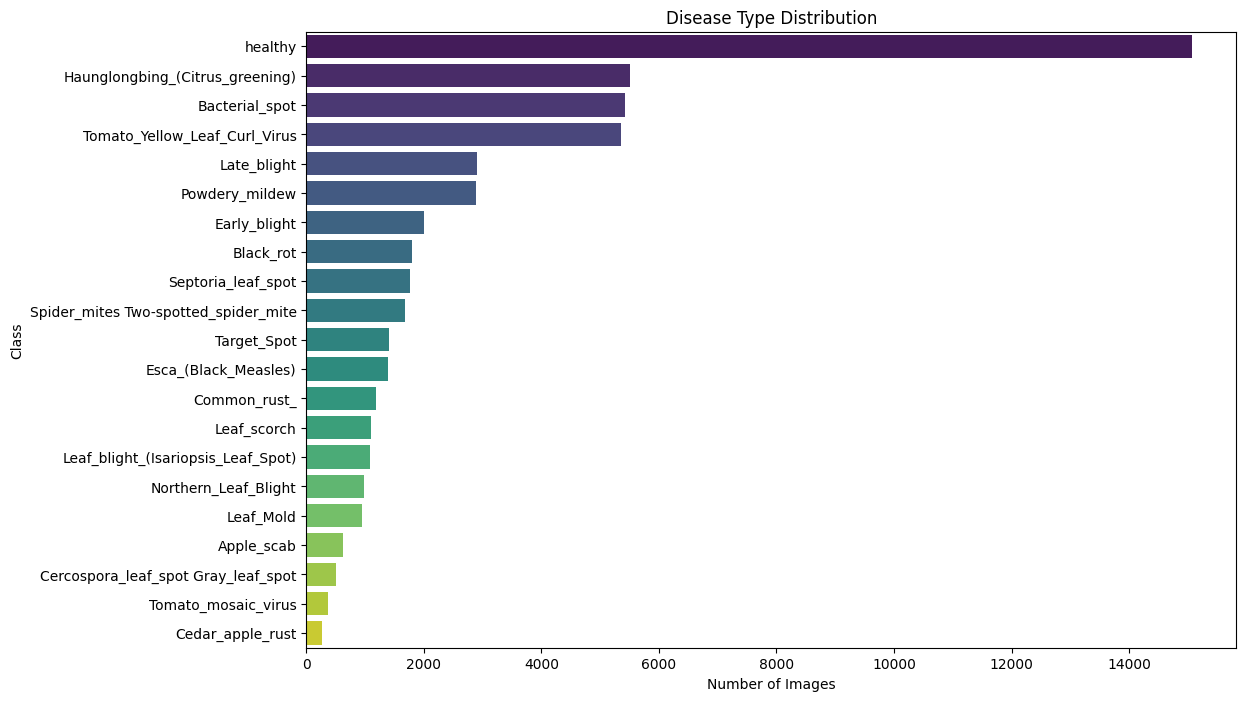

In [ ]:
# visualise disease type distribution
plot_dist(images_df_cleaned, "Disease Type Distribution")

### 2. Data Resampling
Approach (in order):

- Since the healthy class has overwhelmingly more samples, we will carry out random undersampling and bring it down to ~6000 samples (keep it slightly more than the next biggest class)
    
- Stratified splitting of dataset: 70-15-15 ratio (train, val, test)

- For the training set ONLY, resample such that every class has 2000-5000 samples.
    - Randomly undersample classes > 5000 samples (if any)
    - Use data augmentation to randomly oversample classes < 2000 samples.
      - Using keras ImageDataGenerator

In [ ]:
df = images_df_cleaned.copy()
print(df[df['disease_type'] == 'healthy'].shape[0])


15071


#### 1. Undersample healthy class to 6000 samples

In [ ]:
target_count = 6000

# Separate `healthy` and other classes
df_healthy = df[df['disease_type'] == 'healthy'].sample(n=target_count, random_state=42)
df_others = df[df['disease_type'] != 'healthy']
df_resampled = pd.concat([df_healthy, df_others])
print(df_resampled.shape)
print(df_resampled[df_resampled['disease_type'] == 'healthy'].shape[0])

(45213, 4)
6000


#### 2. Stratified train-test split

In [ ]:
from collections import Counter

# Split train+validation and test first (85-15)
df_train_val, df_test = train_test_split(df_resampled, test_size=0.15, stratify=df_resampled['disease_type'], random_state=42)

# then split train and validation (70-15 from total data)
df_train, df_val = train_test_split(df_train_val, test_size=0.1765, stratify=df_train_val['disease_type'], random_state=42) # 0.1765 to make 15% of total

print("Class distribution in train:", Counter(df_train['disease_type']))
print("Class distribution in validation:", Counter(df_val['disease_type']))
print("Class distribution in test:", Counter(df_test['disease_type']))

Class distribution in train: Counter({'healthy': 4200, 'Haunglongbing_(Citrus_greening)': 3855, 'Bacterial_spot': 3795, 'Tomato_Yellow_Leaf_Curl_Virus': 3749, 'Late_blight': 2031, 'Powdery_mildew': 2021, 'Early_blight': 1400, 'Black_rot': 1261, 'Septoria_leaf_spot': 1239, 'Spider_mites Two-spotted_spider_mite': 1173, 'Target_Spot': 982, 'Esca_(Black_Measles)': 968, 'Common_rust_': 834, 'Leaf_scorch': 777, 'Leaf_blight_(Isariopsis_Leaf_Spot)': 753, 'Northern_Leaf_Blight': 689, 'Leaf_Mold': 666, 'Apple_scab': 441, 'Cercospora_leaf_spot Gray_leaf_spot': 359, 'Tomato_mosaic_virus': 261, 'Cedar_apple_rust': 193})
Class distribution in validation: Counter({'healthy': 900, 'Haunglongbing_(Citrus_greening)': 826, 'Bacterial_spot': 813, 'Tomato_Yellow_Leaf_Curl_Virus': 804, 'Late_blight': 435, 'Powdery_mildew': 433, 'Early_blight': 300, 'Black_rot': 270, 'Septoria_leaf_spot': 266, 'Spider_mites Two-spotted_spider_mite': 252, 'Target_Spot': 211, 'Esca_(Black_Measles)': 208, 'Common_rust_': 179, 

#### 3. Resample training set ONLY

In [ ]:
def load_preprocess_image(img_path, target_size=(224, 224)):
    image = Image.open(img_path)
    image = image.resize(target_size)
    # convert to array and normalize pixel values to [0, 1]
    image = np.array(image) / 255.0
    return image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [ ]:
min_samples = 2000
max_samples = 5000

In [ ]:
# Resampling pipeline
augmented_dir = 'plantvillage_dataset/color/augmented_images'  # dir to save augmented imgs
os.makedirs(augmented_dir, exist_ok=True)

df_train_resampled = pd.DataFrame(columns=df_train.columns)

for label, subset in df_train.groupby('disease_type'):
    if len(subset) < min_samples:
        aug_count = min_samples - len(subset)

        # data augmentation
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest',
        )

        augmented_image_paths = []  # collect paths of saved augmented images
        for img_path in subset['image_path']:
            image = load_preprocess_image(img_path)
            image = image.reshape((1,) + image.shape)  # reshape for keras flow
            for _ in range(aug_count // len(subset) + 1):  # generate enough images
                for batch in datagen.flow(image, batch_size=1):
                    # convert the image to the format required by PIL
                    img_array = (batch[0] * 255).astype('uint8')  # Rescale for saving as image
                    img = Image.fromarray(img_array)

                    # define a unique file name
                    img_save_path = os.path.join(augmented_dir, f"{label}_aug_{len(augmented_image_paths)}.jpg")
                    img.save(img_save_path)  # Save image

                    # store path of the saved image
                    augmented_image_paths.append(img_save_path)

                    if len(augmented_image_paths) >= aug_count:
                        break
                if len(augmented_image_paths) >= aug_count:
                    break

        # append augmented images to the df
        df_aug = pd.DataFrame({
            'image_path': augmented_image_paths,  # Replace with augmented image paths if saving them
            'disease_type': label
        })
        df_train_resampled = pd.concat([df_train_resampled, subset, df_aug])

    elif len(subset) > max_samples:
        # randomly undersample classes with more than max_samples
        df_train_resampled = pd.concat([df_train_resampled, subset.sample(n=max_samples, random_state=42)])
    else:
        # use the original subset if within range
        df_train_resampled = pd.concat([df_train_resampled, subset])

In [ ]:
# Delete unneeded images
base_dir = 'plantvillage_dataset/color'
valid_image_paths = set(df_train_resampled['image_path']).union(df_val['image_path']).union(df_test['image_path'])

deleted_count = 0
for root, dirs, files in os.walk(base_dir):
    for file_name in files:
        file_path = os.path.join(root, file_name)

        if file_path not in valid_image_paths:
            try:
                os.remove(file_path)
                deleted_count += 1
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")

print(f"Total images deleted: {deleted_count}")

Deleted: plantvillage_dataset/color/.DS_Store
Deleted: plantvillage_dataset/color/Strawberry___healthy/d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2163.JPG
Deleted: plantvillage_dataset/color/Strawberry___healthy/4005fb13-0d7c-4a30-9ee3-73e9e4cee05e___RS_HL 1688.JPG
Deleted: plantvillage_dataset/color/Strawberry___healthy/29050f21-a393-473e-9f9c-7fd99feef9a7___RS_HL 4533.JPG
Deleted: plantvillage_dataset/color/Strawberry___healthy/a5db3b2a-9806-45c1-b1f8-9d6f414222f2___RS_HL 2067.JPG
Deleted: plantvillage_dataset/color/Strawberry___healthy/c4eca43a-adf9-4d30-a990-8b177165fb04___RS_HL 4708.JPG
Deleted: plantvillage_dataset/color/Strawberry___healthy/d454c3f8-ca2e-4935-9c09-3b6a480ac097___RS_HL 1870.JPG
Deleted: plantvillage_dataset/color/Strawberry___healthy/03fe6806-ca61-46c1-8889-45e40228c168___RS_HL 4632.JPG
Deleted: plantvillage_dataset/color/Strawberry___healthy/7ba8b9d1-9f10-479c-901a-b038f042f0ce___RS_HL 4749.JPG
Deleted: plantvillage_dataset/color/Strawberry___healthy/a53942e6-

In [ ]:
# Check final distribution
print("Final class dist in training set:", Counter(df_train_resampled['disease_type']))

# Using min 2000 and max 5000 --> final training set has 2021 samples in smallest class and 4200 in biggest class.

Final class dist in training set: Counter({'healthy': 4200, 'Haunglongbing_(Citrus_greening)': 3855, 'Bacterial_spot': 3795, 'Tomato_Yellow_Leaf_Curl_Virus': 3749, 'Early_blight': 3399, 'Black_rot': 3260, 'Septoria_leaf_spot': 3238, 'Spider_mites Two-spotted_spider_mite': 3172, 'Target_Spot': 2981, 'Esca_(Black_Measles)': 2967, 'Common_rust_': 2833, 'Leaf_scorch': 2776, 'Leaf_blight_(Isariopsis_Leaf_Spot)': 2752, 'Northern_Leaf_Blight': 2688, 'Leaf_Mold': 2665, 'Apple_scab': 2440, 'Cercospora_leaf_spot Gray_leaf_spot': 2358, 'Tomato_mosaic_virus': 2260, 'Cedar_apple_rust': 2192, 'Late_blight': 2031, 'Powdery_mildew': 2021})


#### Visualize distributions of training, validation and test sets

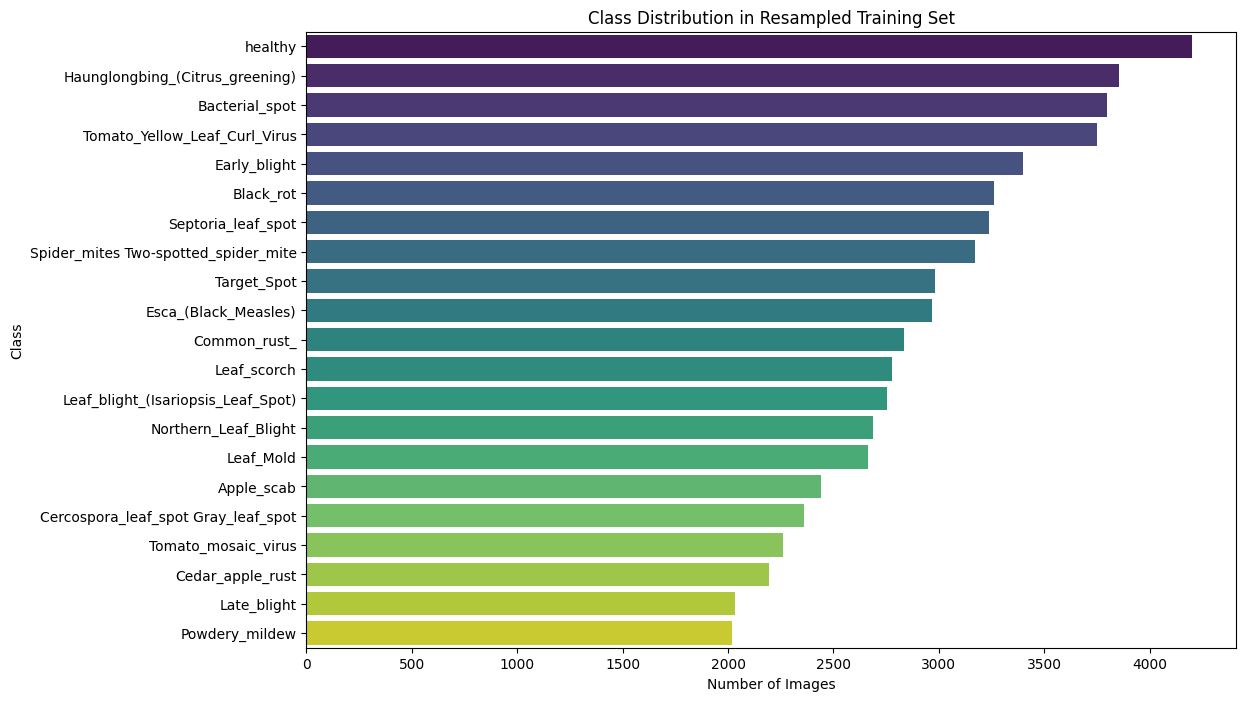

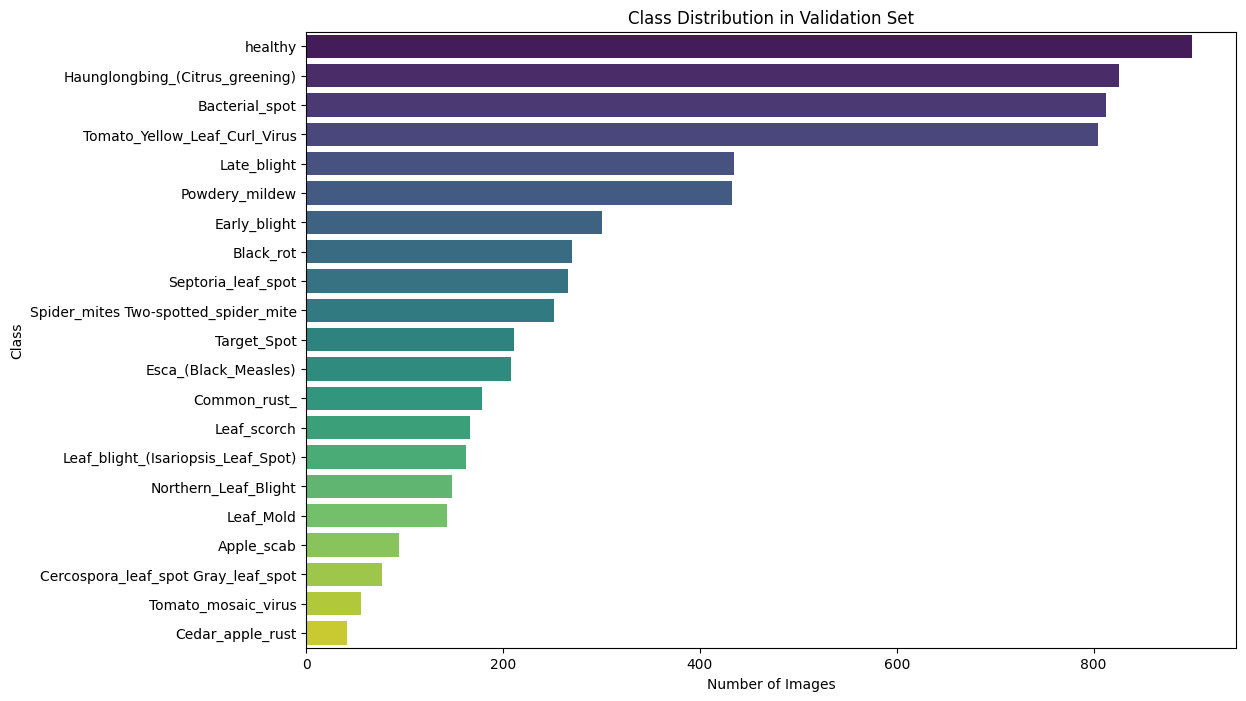

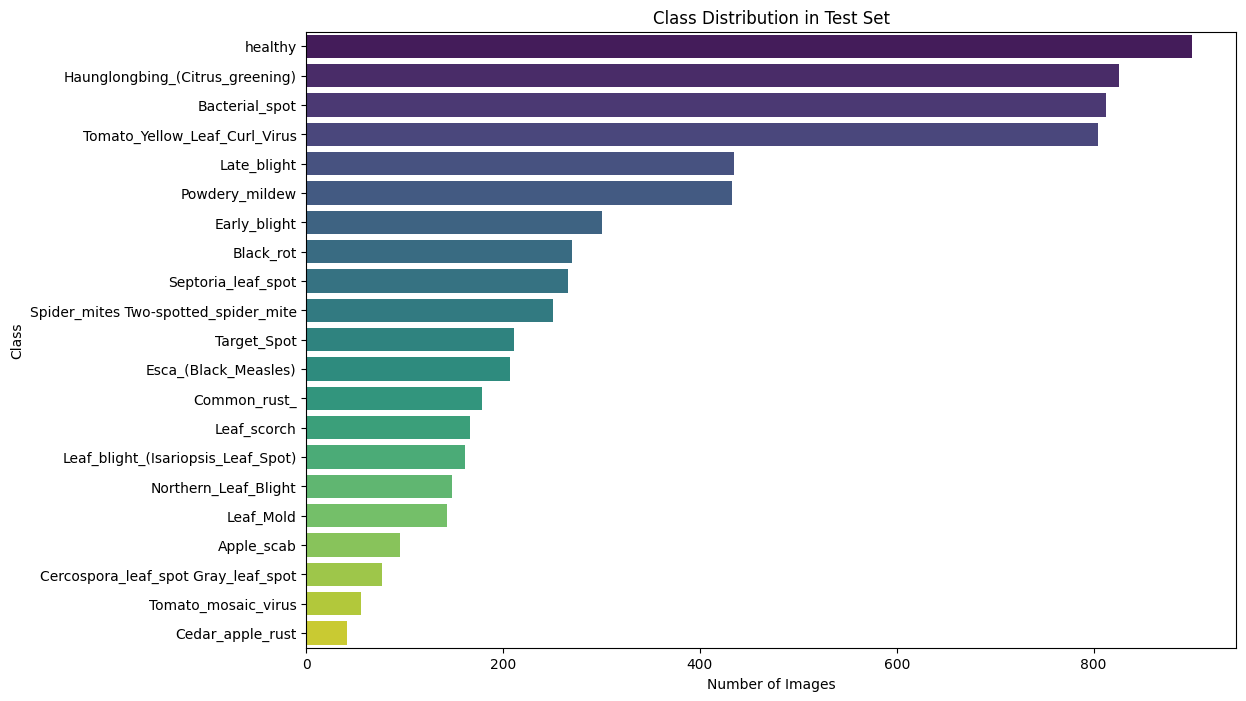

In [ ]:
# Visualize sets distribution
plot_dist(df_train_resampled, 'Class Distribution in Resampled Training Set')
plot_dist(df_val, 'Class Distribution in Validation Set')
plot_dist(df_test, 'Class Distribution in Test Set')

In [ ]:
# Save dataframes
df_train_resampled.to_csv('resampled_training_set.csv', index=False)
df_val.to_csv('validation_set.csv', index=False)
df_test.to_csv('test_set.csv', index=False)